# TP Introduction to Model Parallelism

In [1]:
import os

# The distribution API is only implemented for the JAX backend for now.
os.environ["KERAS_BACKEND"] = "jax"

import keras
from keras import layers
import jax
import numpy as np
from tensorflow import data as tf_data  # For dataset input.

2024-04-22 09:07:48.860589: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-04-22 09:07:48.860690: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-04-22 09:07:48.954989: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


### GPUs Specifications

Before executing the rest of the notebook, let's make sure we have access to two T4.

In [2]:
!nvidia-smi

Mon Apr 22 09:07:57 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.129.03             Driver Version: 535.129.03   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   58C    P8              12W /  70W |      0MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

## MNIST dataset

In [3]:
import tensorflow as tf
import matplotlib.pyplot as plt
import time

## Data Loading new fashion_mnist dataset
(X_train, y_train), (X_test, y_test) = tf.keras.datasets.mnist.load_data()

img_rows, img_cols = 28, 28
input_shape = (img_rows, img_cols, 1)

print(f"X_train Before: {X_train.shape}")
X_train = X_train.reshape(X_train.shape[0], img_rows, img_cols, 1)
print(f"X_train After: {X_train.shape}")

print(f"X_test Before: {X_test.shape}")
X_test = X_test.reshape(X_test.shape[0], img_rows, img_cols, 1)
print(f"X_test After: {X_test.shape}")

## converting the images to float32
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')

## converting the range to [0,1]
X_train /= 255
X_test /= 255

11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
X_train Before: (60000, 28, 28)
X_train After: (60000, 28, 28, 1)
X_test Before: (10000, 28, 28)
X_test After: (10000, 28, 28, 1)


In [4]:
len(X_train)

60000

Let's take a quick look at the data

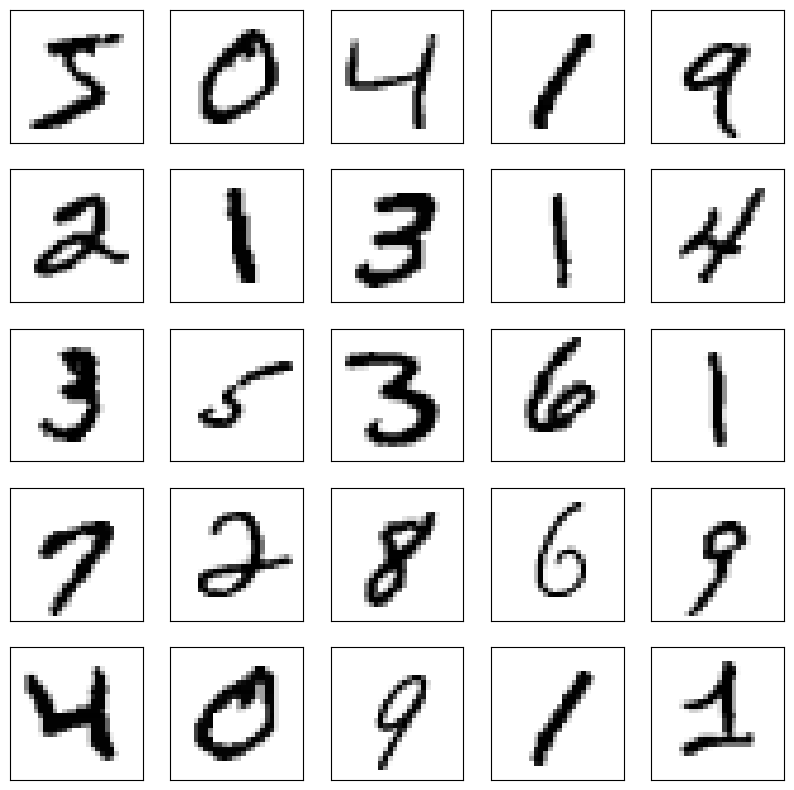

In [5]:
plt.figure(figsize=(10,10))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(X_train[i], cmap=plt.cm.binary)
plt.show()

To make things better, lets put the data on a TF.dataset.

One important detail here is the BATCH_SIZE. To get the benefits of multiple GPUs, we have to optimize their use, otherwise you won't see the gains.

In [6]:
BUFFER_SIZE = 10000
BATCH_SIZE_PER_REPLICA = 1024

def get_batch_size(num_gpus=1):
    batch_size = BATCH_SIZE_PER_REPLICA * num_gpus
    print(f'BATCH_SIZE = {batch_size}')
    return batch_size

# Wrap data in Dataset objects.
train_data = tf.data.Dataset.from_tensor_slices((X_train, y_train))
test_data = tf.data.Dataset.from_tensor_slices((X_test, y_test))

# the batch size will be defined later based on the number of used GPUs
options = tf.data.Options()
options.experimental_distribute.auto_shard_policy = tf.data.experimental.AutoShardPolicy.OFF
train_data = train_data.with_options(options).cache().shuffle(BUFFER_SIZE).prefetch(tf.data.AUTOTUNE)
test_data = test_data.with_options(options)

## Defining a Distribution Strategy

To use Multi GPU, we are going to use the `tf.distribute.Strategy` API, 
more specifically `tf.distribute.MirroredStrategy`

This strategy will do the spliting of the work between both T4s for you

In [7]:
def build_model():
    model = tf.keras.Sequential([
        tf.keras.layers.Conv2D(32, [3, 3], activation='relu', input_shape=(28, 28, 1)),
        tf.keras.layers.Conv2D(64, [3, 3], activation='relu'),
        tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
        tf.keras.layers.Dropout(0.25),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(128, activation='relu'),
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.Dense(10, activation='softmax')
    ])

    model.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                optimizer=tf.keras.optimizers.Adam(),
                metrics=['accuracy'])

    return model

In [8]:
regular_model = build_model()
regular_model.summary()

/opt/conda/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 26, 26, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 24, 24, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 12, 12, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 12, 12, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 9216)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │     1,179,776 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,199,882 (4.58 MB)

 Trainable params: 1,199,882 (4.58 MB)

 Non-trainable params: 0 (0.00 B)

## Warmup

The framework will load aditional libraries not yet in memory and this would impact the timing of training the model.

In [9]:
get_batch_size()

BATCH_SIZE = 1024


1024

In [11]:
EPOCHS = 1

d_train_data = train_data.batch(get_batch_size())
history = regular_model.fit(d_train_data, epochs=EPOCHS)

BATCH_SIZE = 1024
59/59 ━━━━━━━━━━━━━━━━━━━━ 10s 91ms/step - accuracy: 0.6326 - loss: 1.8929


## Building on 1 GPU

In [12]:
EPOCHS = 30

regular_train_data = train_data.batch(get_batch_size())


start_time_single = time.time()
history_regular = regular_model.fit(regular_train_data, epochs=EPOCHS)
final_time_single = time.time() - start_time_single
print("--- %s seconds ---" % (final_time_single))

BATCH_SIZE = 1024
Epoch 1/30
59/59 ━━━━━━━━━━━━━━━━━━━━ 2s 35ms/step - accuracy: 0.9170 - loss: 1.5486
Epoch 2/30
59/59 ━━━━━━━━━━━━━━━━━━━━ 2s 35ms/step - accuracy: 0.9476 - loss: 1.5171
Epoch 3/30
59/59 ━━━━━━━━━━━━━━━━━━━━ 2s 35ms/step - accuracy: 0.9628 - loss: 1.5016
Epoch 4/30
59/59 ━━━━━━━━━━━━━━━━━━━━ 2s 35ms/step - accuracy: 0.9691 - loss: 1.4947
Epoch 5/30
59/59 ━━━━━━━━━━━━━━━━━━━━ 2s 35ms/step - accuracy: 0.9732 - loss: 1.4902
Epoch 6/30
59/59 ━━━━━━━━━━━━━━━━━━━━ 2s 35ms/step - accuracy: 0.9767 - loss: 1.4865
Epoch 7/30
59/59 ━━━━━━━━━━━━━━━━━━━━ 2s 35ms/step - accuracy: 0.9788 - loss: 1.4839
Epoch 8/30
59/59 ━━━━━━━━━━━━━━━━━━━━ 2s 35ms/step - accuracy: 0.9807 - loss: 1.4821
Epoch 9/30
59/59 ━━━━━━━━━━━━━━━━━━━━ 2s 35ms/step - accuracy: 0.9815 - loss: 1.4812
Epoch 10/30
59/59 ━━━━━━━━━━━━━━━━━━━━ 2s 35ms/step - accuracy: 0.9827 - loss: 1.4799
Epoch 11/30
59/59 ━━━━━━━━━━━━━━━━━━━━ 2s 35ms/step - accuracy: 0.9838 - loss: 1.4788
Epoch 12/30
59/59 ━━━━━━━━━━━━━━━━━━━━ 2s 36m

### Kaggle GPU summary for regular_model training 

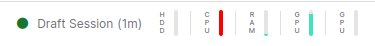

## Building with Model Parallelism

In [13]:
devices = keras.distribution.list_devices()
devices

['gpu:0', 'gpu:1']

In [14]:
mesh_2d = keras.distribution.DeviceMesh(
    shape=(1, 2), axis_names=["model_1", "model_2"], devices=devices
)

layout_map = keras.distribution.LayoutMap(mesh_2d)


layout_map['conv2d.*kernel'] = ("model_1", None)
layout_map['conv2d.*bias'] = ('model_1',)
layout_map['dense.*kernel'] = (None, "model_2")
layout_map['dense.*bias'] = ('model_2',)


model_parallel = keras.distribution.ModelParallel(
    mesh_2d, layout_map, batch_dim_name="model_1"
)

keras.distribution.set_distribution(model_parallel)

In [15]:
multi_gpu_model = build_model()
multi_gpu_model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_2 (Conv2D)               │ (None, 26, 26, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 24, 24, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 12, 12, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 12, 12, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 9216)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │     1,179,776 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,199,882 (4.58 MB)

 Trainable params: 1,199,882 (4.58 MB)

 Non-trainable params: 0 (0.00 B)

## Warmup

The framework will load aditional libraries not yet in memory and this would impact the timing of training the model.

get_batch_size()

In [16]:
EPOCHS = 1

d_train_data = train_data.batch(get_batch_size())
history = multi_gpu_model.fit(d_train_data, epochs=EPOCHS)

BATCH_SIZE = 1024
59/59 ━━━━━━━━━━━━━━━━━━━━ 7s 75ms/step - accuracy: 0.6399 - loss: 1.8824


## Building on 2 GPUs

In [17]:
EPOCHS = 30

start_time_multi = time.time()
history_multi = multi_gpu_model.fit(d_train_data, epochs=EPOCHS)
final_time_multi = time.time() - start_time_multi
print("--- %s seconds ---" % (final_time_multi))

Epoch 1/30
59/59 ━━━━━━━━━━━━━━━━━━━━ 3s 44ms/step - accuracy: 0.9096 - loss: 1.5558
Epoch 2/30
59/59 ━━━━━━━━━━━━━━━━━━━━ 3s 43ms/step - accuracy: 0.9466 - loss: 1.5184
Epoch 3/30
59/59 ━━━━━━━━━━━━━━━━━━━━ 3s 43ms/step - accuracy: 0.9639 - loss: 1.5007
Epoch 4/30
59/59 ━━━━━━━━━━━━━━━━━━━━ 3s 43ms/step - accuracy: 0.9704 - loss: 1.4932
Epoch 5/30
59/59 ━━━━━━━━━━━━━━━━━━━━ 3s 43ms/step - accuracy: 0.9756 - loss: 1.4880
Epoch 6/30
59/59 ━━━━━━━━━━━━━━━━━━━━ 3s 43ms/step - accuracy: 0.9775 - loss: 1.4856
Epoch 7/30
59/59 ━━━━━━━━━━━━━━━━━━━━ 3s 42ms/step - accuracy: 0.9790 - loss: 1.4838
Epoch 8/30
59/59 ━━━━━━━━━━━━━━━━━━━━ 3s 42ms/step - accuracy: 0.9811 - loss: 1.4818
Epoch 9/30
59/59 ━━━━━━━━━━━━━━━━━━━━ 3s 43ms/step - accuracy: 0.9830 - loss: 1.4797
Epoch 10/30
59/59 ━━━━━━━━━━━━━━━━━━━━ 3s 43ms/step - accuracy: 0.9826 - loss: 1.4798
Epoch 11/30
59/59 ━━━━━━━━━━━━━━━━━━━━ 3s 43ms/step - accuracy: 0.9847 - loss: 1.4779
Epoch 12/30
59/59 ━━━━━━━━━━━━━━━━━━━━ 3s 43ms/step - accuracy:

### Kaggle GPU summary for multi_gpu_model training 

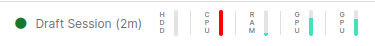

## Performance Comparison

### Accuracy Comparison

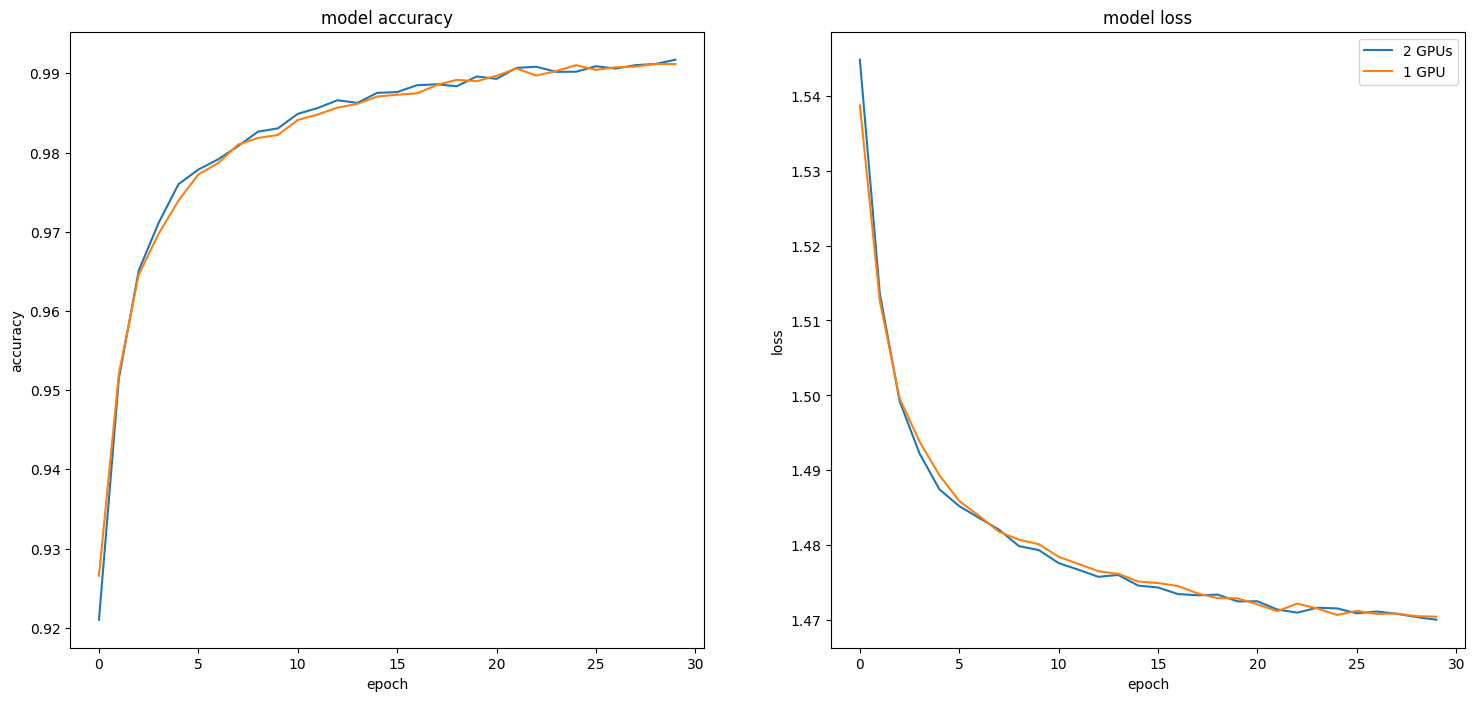

In [18]:
fig, axs = plt.subplots(1, 2,figsize=(18,8))
axs[0].plot(history_multi.history['accuracy'],label = '2 GPUs')
axs[0].plot(history_regular.history['accuracy'],label = '1 GPU')
axs[0].set_title('model accuracy')
axs[0].set_ylabel('accuracy')
axs[0].set_xlabel('epoch')


axs[1].plot(history_multi.history['loss'],label = '2 GPUs')
axs[1].plot(history_regular.history['loss'],label = '1 GPU')
axs[1].set_title('model loss')
axs[1].set_ylabel('loss')
axs[1].set_xlabel('epoch')

plt.legend()
plt.show()

### Computing Power Comparison

We achieve -19.0 percent of scaling


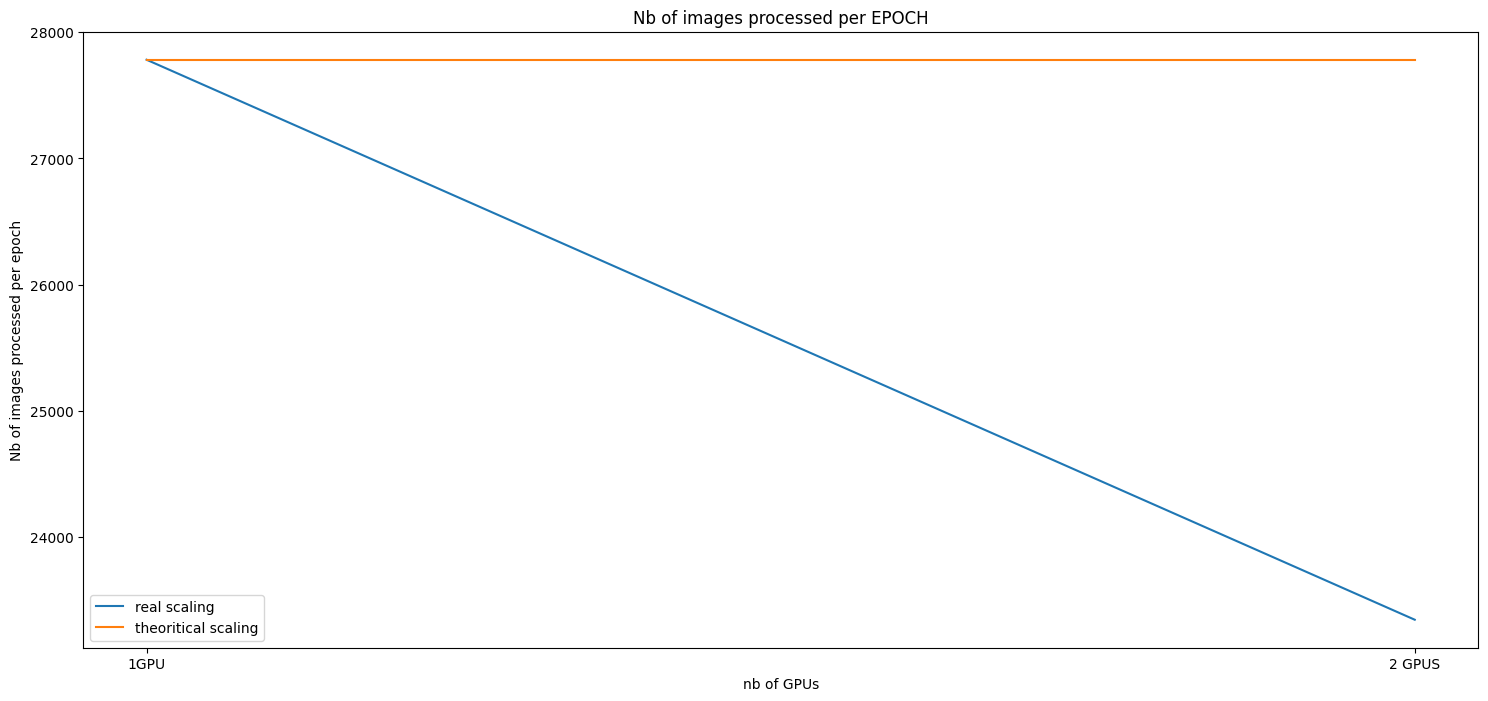

In [24]:
plt.figure(figsize=(18,8))
nb_images = len(train_data)
plt.plot(['1GPU','2 GPUS'],[nb_images/(final_time_single/EPOCHS),nb_images/(final_time_multi/EPOCHS)],label = 'real scaling')
plt.plot(['1GPU','2 GPUS'],[nb_images/(final_time_single/EPOCHS),nb_images/(final_time_single/EPOCHS)],label = 'theoritical scaling')
plt.title('Nb of images processed per EPOCH')
plt.ylabel('Nb of images processed per epoch')
plt.xlabel('nb of GPUs')
plt.legend()
print("We achieve %s percent of scaling"% round((100 - (final_time_multi*100/final_time_single)), 2))

Theorically, dividing this little model inside 2 different GPUs should not help at all to gain speed. Here we can see that in our case, GPUs waiting each others is even worse in term of time gained

We lose approximately 19% of performances.